In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])    # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])    # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# rewrite
class Linear: 
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self, x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].gamma *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1:]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of params in total

for p in parameters:
    p.requires_grad = True

47024


In [7]:
(torch.randn(1000)*0.2).std()

tensor(0.1992)

In [8]:
(5/3) / (30**0.5)

0.3042903097250923

tensor(0.0105) tensor(1.0056)
tensor(-0.0021) tensor(1.0086)


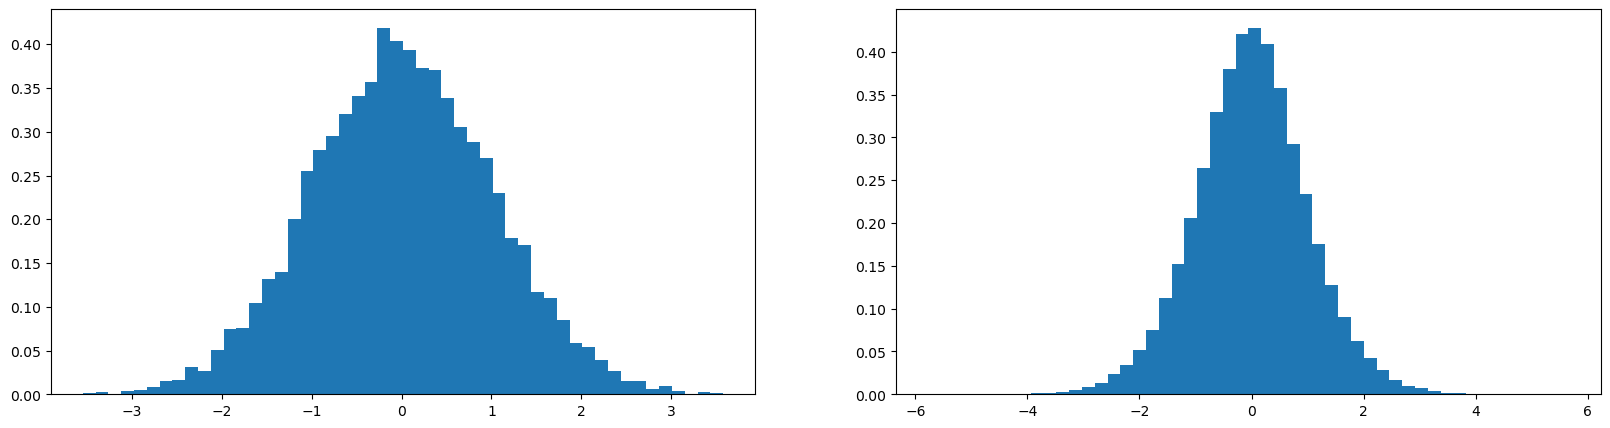

In [9]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
context = torch.zeros((batch_size, block_size), dtype=torch.long)

lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concat the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 1.0 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    

    if i >=1000:
        break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean +0.02, std 0.63, saturated 3.91%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated 3.53%
layer 8 (      Tanh): mean -0.02, std 0.63, saturated 3.09%
layer 11 (      Tanh): mean -0.01, std 0.63, saturated 2.69%
layer 14 (      Tanh): mean +0.02, std 0.64, saturated 3.34%


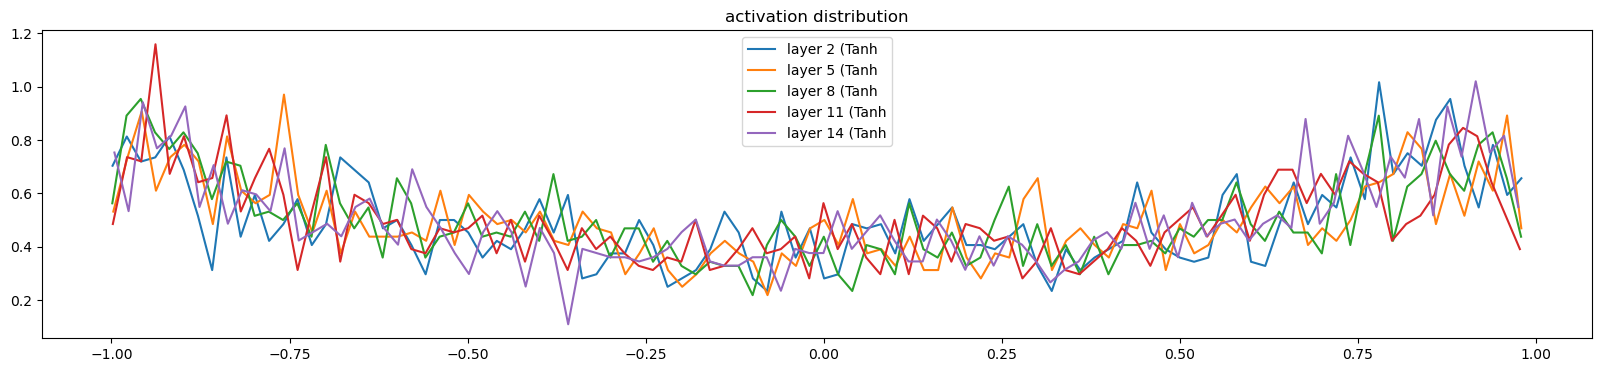

In [11]:
# visualize histograms SATURATION
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.000000, std 4.081717e-03
layer 5 (      Tanh): mean -0.000000, std 3.513452e-03
layer 8 (      Tanh): mean +0.000000, std 3.458266e-03
layer 11 (      Tanh): mean -0.000000, std 3.407234e-03
layer 14 (      Tanh): mean +0.000000, std 3.295505e-03


Text(0.5, 1.0, 'gradient distribution')

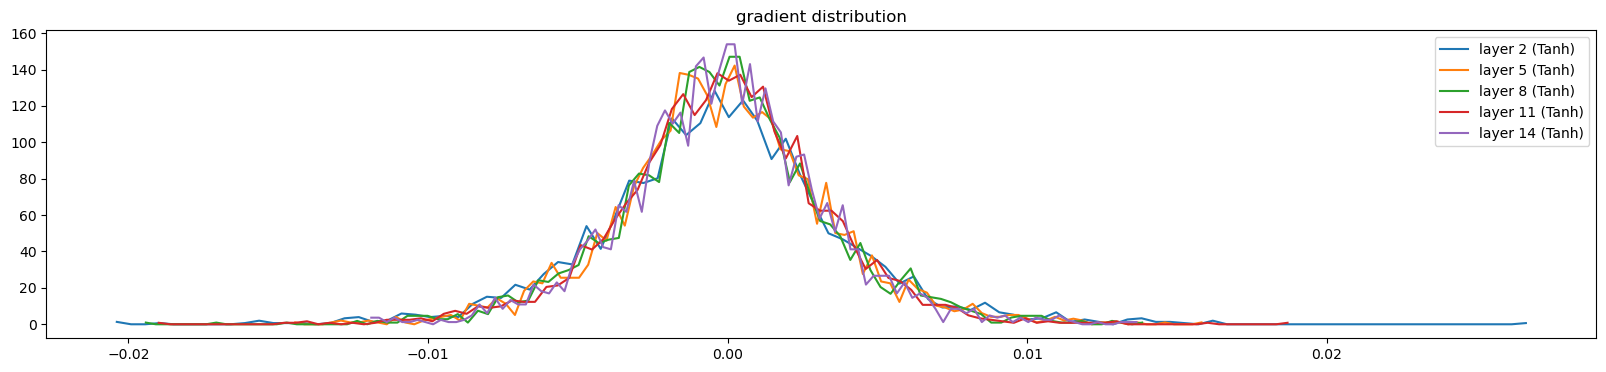

In [12]:
# visualize historgrams GRADIENT
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__,t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.340201e-03 | grad:data ratio 8.083650e-03
weight  (30, 100) | mean +0.000061 | std 2.610466e-03 | grad:data ratio 2.540103e-03
weight (100, 100) | mean -0.000013 | std 1.353518e-03 | grad:data ratio 1.356914e-03
weight (100, 100) | mean -0.000005 | std 1.178781e-03 | grad:data ratio 1.169537e-03
weight (100, 100) | mean -0.000005 | std 1.124870e-03 | grad:data ratio 1.120831e-03
weight (100, 100) | mean +0.000006 | std 1.150513e-03 | grad:data ratio 1.145343e-03
weight  (100, 27) | mean -0.000025 | std 2.196451e-03 | grad:data ratio 2.218108e-03


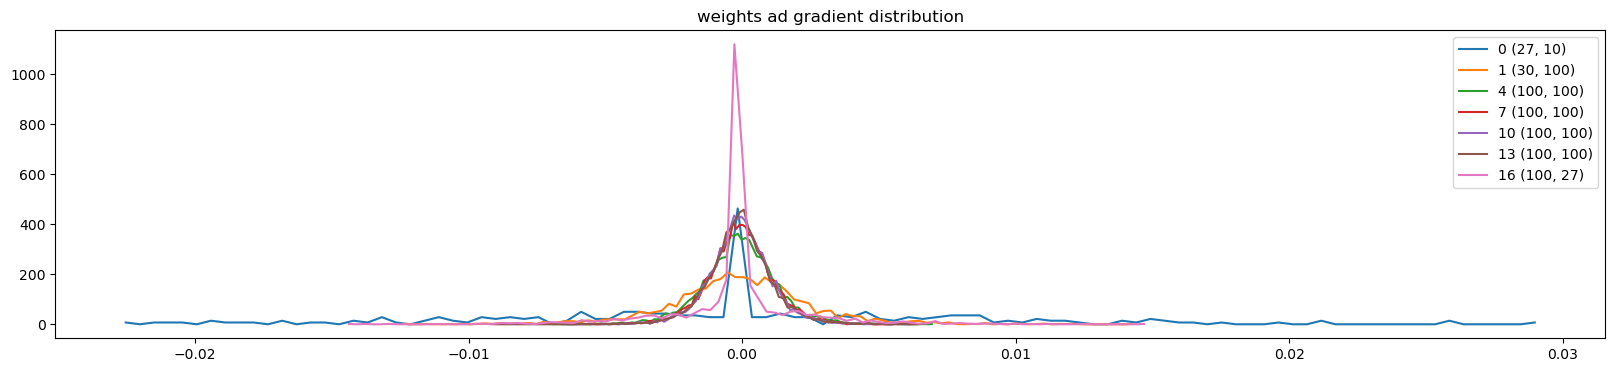

In [13]:
# vis params
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights ad gradient distribution');

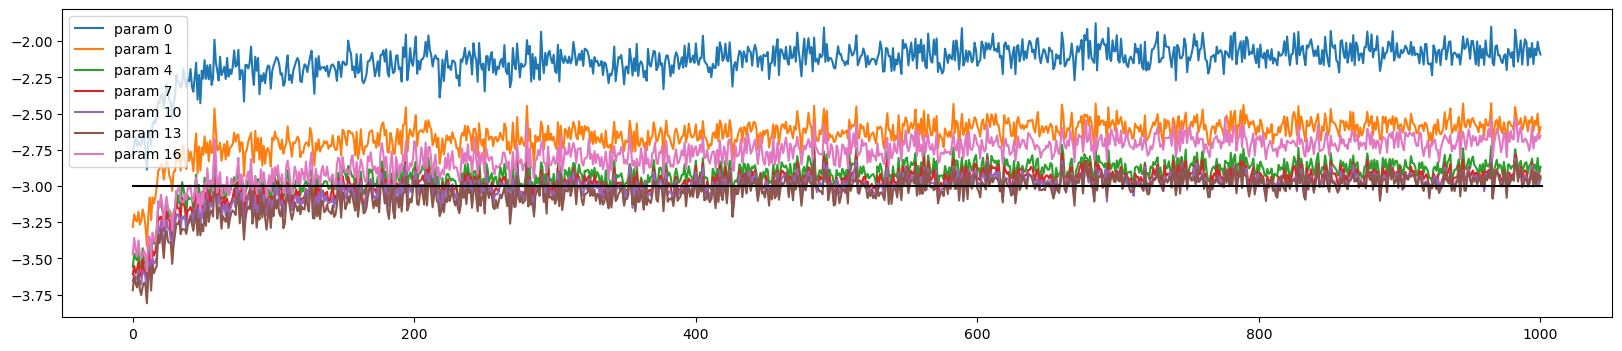

In [14]:
# plot update ratios

plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running+bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

NameError: name 'W1' is not defined

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[context]  # (batch_size, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word